# CIFAR-100 — Baseline vs DropPath (Stochastic Depth) Pipeline

Bu notebook şunları yapar:

- CIFAR-100 **DataLoader** (train/test augmentation + normalize)
- **Aynı backbone** ile 2 model:
  1) **Baseline** (DropPath = 0)
  2) **DropPath** (derinliğe göre schedule + opsiyonel warmup)
- 15 epoch eğitim
- **Train loss / Test loss / Test accuracy** grafikleri
- Ek olarak: birkaç batch üzerinde **accuracy** ve örnek tahmin çıktısı

> ⚠️ Eğer `import torchvision` hatası alıyorsan (özellikle `av.video has no attribute frame`):  
> Bu PyAV/torchvision uyumsuzluğu. Çözüm hücresi notebook’ta var.


## 0) Ortam Kontrolü (torchvision import hatası için)

Bazı ortamlarda `import torchvision` şu hatayı patlatır:

- `AttributeError: module 'av.video' has no attribute 'frame'`

Bu genelde **PyAV (av)** paketi ile **torchvision** uyumsuzluğudur.

Hızlı çözüm seçenekleri:
- `pip uninstall av`  (çoğu durumda yeterli; CIFAR için PyAV gereksiz)
- veya torch/torchvision sürümlerini eşleştir (conda/pip üzerinden)

Aşağıdaki hücre torchvision import’u dener; patlarsa direkt çözüm komutlarını gösterir.


In [4]:
import sys
import torch

try:
    import torchvision  # noqa
    from torchvision import transforms as T  # noqa
    TORCHVISION_OK = True
except Exception as e:
    TORCHVISION_OK = False
    print("❌ torchvision import failed. Hata mesajı:\n", repr(e), "\n")
    print("Çözüm (çoğu durumda yeterli):")
    print("  pip uninstall -y av")
    print("  pip install --upgrade --force-reinstall torchvision")
    print("\nConda kullanıyorsan:")
    print("  conda remove -y av")
    print("  conda install pytorch torchvision -c pytorch")
    raise

print("✅ torch:", torch.__version__)
print("✅ torchvision:", torchvision.__version__)


✅ torch: 2.5.1+cu121
✅ torchvision: 0.20.1+cu121


## 1) Seed + Device

In [5]:
import os, random
import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 2) CIFAR-100 DataLoaders

- Train: random crop + horizontal flip
- Test: sadece normalize
- CIFAR-100 mean/std (yaygın kullanım)


In [6]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets.cifar import CIFAR100
from torchvision import transforms as T

# CIFAR-100 mean/std
mean = (0.5071, 0.4865, 0.4409)
std  = (0.2673, 0.2564, 0.2762)

train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
])

test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

data_root = r"C:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\regularization_techniques\path_based\drop_path\to_compose\data"

train_set = CIFAR100(root=data_root, train=True, download=True, transform=train_tfms)
test_set  = CIFAR100(root=data_root, train=False, download=True, transform=test_tfms)

BATCH_SIZE = 128
num_workers = 0  
pin_memory = (device == "cuda")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)

len(train_loader), len(test_loader)


100%|██████████| 169M/169M [02:34<00:00, 1.10MB/s] 


Extracting C:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\regularization_techniques\path_based\drop_path\to_compose\data\cifar-100-python.tar.gz to C:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\regularization_techniques\path_based\drop_path\to_compose\data
Files already downloaded and verified


(391, 79)

## 3) DropPath + Aynı Backbone ile 2 Model

- **Baseline**: DropPath oranı 0 (yani kapalı)
- **DropPath**: derinliğe göre lineer artan drop (max_drop) + opsiyonel warmup

> DropPath kuralı: **residual branch çıktısına** ve **toplamadan önce** uygulanır.


In [7]:
import torch
import torch.nn as nn

class DropPath(nn.Module):
    def __init__(self,
                 max_drop: float = 0.0,
                 layer_idx: int | None = None,
                 num_layers: int | None = None,
                 warmup_steps: int = 0,
                 batchwise: bool = True,
                 store_mask: bool = False):
        super().__init__()
        self.max_drop = float(max_drop)
        self.layer_idx = layer_idx
        self.num_layers = num_layers
        self.warmup_steps = int(warmup_steps)
        self.batchwise = bool(batchwise)
        self.store_mask = bool(store_mask)
        self.register_buffer("step", torch.zeros((), dtype=torch.long))
        self.last_mask = None

    def layer_scaled_drop(self) -> float:
        if self.layer_idx is None or self.num_layers is None or self.num_layers <= 1:
            return self.max_drop
        frac = float(self.layer_idx) / float(self.num_layers - 1)
        return self.max_drop * frac

    def warmup_drop_prob(self, drop: float) -> float:
        if self.warmup_steps <= 0:
            return drop
        s = int(self.step.item())
        t = min(max(s / float(self.warmup_steps), 0.0), 1.0)
        return drop * t

    def current_drop_prob(self) -> float:
        d = self.layer_scaled_drop()
        d = self.warmup_drop_prob(d)
        if d < 0.0:
            d = 0.0
        if d >= 1.0:
            d = 0.999
        return d

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            self.step += 1

        drop_prob = self.current_drop_prob()
        if drop_prob <= 0.0 or (not self.training):
            if self.store_mask:
                self.last_mask = None
            return x

        keep_prob = 1.0 - drop_prob

        if self.batchwise:
            mask_shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        else:
            mask_shape = x.shape

        mask = torch.empty(mask_shape, device=x.device, dtype=torch.float32).bernoulli_(keep_prob)
        mask = mask.to(dtype=x.dtype)

        if self.store_mask:
            self.last_mask = mask.detach()

        return x * mask / keep_prob


def _get_act(act: str) -> nn.Module:
    a = act.lower()
    if a == "relu":
        return nn.ReLU(inplace=True)
    if a in ("silu", "swish"):
        return nn.SiLU(inplace=True)
    raise ValueError("act: 'relu' | 'silu'")


class ConvBNAct(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1, act="relu"):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.act = _get_act(act)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class BasicResBlock(nn.Module):
    """Conv-BN-Act -> Conv-BN -> (DropPath) -> +skip -> Act"""
    def __init__(self, cin, cout, stride=1, act="relu", dp: DropPath | None = None):
        super().__init__()
        self.conv1 = ConvBNAct(cin, cout, k=3, s=stride, p=1, act=act)
        self.conv2 = nn.Sequential(
            nn.Conv2d(cout, cout, 3, padding=1, bias=False),
            nn.BatchNorm2d(cout),
        )
        self.act = _get_act(act)
        self.dp = dp

        self.skip = nn.Identity()
        if stride != 1 or cin != cout:
            self.skip = nn.Sequential(
                nn.Conv2d(cin, cout, 1, stride=stride, bias=False),
                nn.BatchNorm2d(cout),
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.conv2(out)
        if self.dp is not None:
            out = self.dp(out)  # DropPath residual branch'e toplama öncesi
        out = self.act(out + identity)
        return out


class ResNetSmall(nn.Module):
    """Aynı backbone. drop_path_max=0 ise baseline olur."""
    def __init__(self, num_classes=100, act="relu",
                 drop_path_max: float = 0.0, warmup_steps: int = 0, batchwise: bool = True):
        super().__init__()
        self.total_blocks = 6
        self._idx = 0

        self.stem = ConvBNAct(3, 64, k=3, s=1, p=1, act=act)

        self.stage1 = nn.Sequential(
            self._make_block(64, 64, stride=1, act=act, drop_path_max=drop_path_max, warmup_steps=warmup_steps, batchwise=batchwise),
            self._make_block(64, 64, stride=1, act=act, drop_path_max=drop_path_max, warmup_steps=warmup_steps, batchwise=batchwise),
        )
        self.stage2 = nn.Sequential(
            self._make_block(64, 128, stride=2, act=act, drop_path_max=drop_path_max, warmup_steps=warmup_steps, batchwise=batchwise),
            self._make_block(128, 128, stride=1, act=act, drop_path_max=drop_path_max, warmup_steps=warmup_steps, batchwise=batchwise),
        )
        self.stage3 = nn.Sequential(
            self._make_block(128, 256, stride=2, act=act, drop_path_max=drop_path_max, warmup_steps=warmup_steps, batchwise=batchwise),
            self._make_block(256, 256, stride=1, act=act, drop_path_max=drop_path_max, warmup_steps=warmup_steps, batchwise=batchwise),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes),
        )

    def _make_block(self, cin, cout, stride, act, drop_path_max, warmup_steps, batchwise):
        dp = DropPath(
            max_drop=drop_path_max,
            layer_idx=self._idx,
            num_layers=self.total_blocks,
            warmup_steps=warmup_steps,
            batchwise=batchwise,
            store_mask=False,
        ) if drop_path_max > 0 else None

        self._idx += 1
        return BasicResBlock(cin, cout, stride=stride, act=act, dp=dp)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        return self.head(x)


## 4) Train / Eval Fonksiyonları (AMP güncel API)

Torch uyarılarını yememek için:
- `torch.amp.autocast(device_type='cuda')`
- `torch.amp.GradScaler('cuda')`


In [8]:
from torch import amp

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: str):
    model.eval()
    total = 0
    correct = 0
    loss_sum = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total


def train_one_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: str,
    epochs: int = 15,
    lr: float = 3e-4,
    wd: float = 1e-4,
):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    use_cuda_amp = (device == "cuda")
    scaler = amp.GradScaler("cuda", enabled=use_cuda_amp)

    history = {"train_loss": [], "test_loss": [], "test_acc": []}

    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        total = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with amp.autocast(device_type=device, enabled=use_cuda_amp):
                logits = model(x)
                loss = F.cross_entropy(logits, y)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running += loss.item() * x.size(0)
            total += x.size(0)

        train_loss = running / total
        test_loss, test_acc = evaluate(model, test_loader, device)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(f"Epoch {ep:02d}/{epochs} | train_loss={train_loss:.4f} test_loss={test_loss:.4f} acc={test_acc:.4f}")

    return history


## 5) Çalıştır: Baseline vs DropPath (15 epoch)

- Baseline: `drop_path_max = 0.0`
- DropPath: `drop_path_max = 0.1`
- Warmup: `warmup_steps = 2000` (istersen 0 yap)


In [9]:
EPOCHS = 15
NUM_CLASSES = 100

# Baseline (DropPath kapalı)
set_seed(42)
baseline = ResNetSmall(num_classes=NUM_CLASSES, act="relu", drop_path_max=0.0, warmup_steps=0, batchwise=True)

# DropPath (aktif)
set_seed(42)
droppath = ResNetSmall(num_classes=NUM_CLASSES, act="relu", drop_path_max=0.1, warmup_steps=2000, batchwise=True)

print("=== BASELINE ===")
hist_base = train_one_model(baseline, train_loader, test_loader, device, epochs=EPOCHS, lr=3e-4, wd=1e-4)

print("\n=== DROPPATH ===")
hist_dp = train_one_model(droppath, train_loader, test_loader, device, epochs=EPOCHS, lr=3e-4, wd=1e-4)


=== BASELINE ===
Epoch 01/15 | train_loss=3.6403 test_loss=3.2269 acc=0.2072
Epoch 02/15 | train_loss=2.8982 test_loss=2.7645 acc=0.2962
Epoch 03/15 | train_loss=2.4827 test_loss=2.5390 acc=0.3465
Epoch 04/15 | train_loss=2.1873 test_loss=2.1761 acc=0.4194
Epoch 05/15 | train_loss=1.9594 test_loss=2.1045 acc=0.4390
Epoch 06/15 | train_loss=1.7772 test_loss=2.1411 acc=0.4408
Epoch 07/15 | train_loss=1.6379 test_loss=1.8475 acc=0.5000
Epoch 08/15 | train_loss=1.5233 test_loss=1.7631 acc=0.5258
Epoch 09/15 | train_loss=1.4236 test_loss=1.7717 acc=0.5211
Epoch 10/15 | train_loss=1.3310 test_loss=1.6939 acc=0.5403
Epoch 11/15 | train_loss=1.2553 test_loss=1.5432 acc=0.5773
Epoch 12/15 | train_loss=1.1846 test_loss=1.5293 acc=0.5812
Epoch 13/15 | train_loss=1.1278 test_loss=1.4790 acc=0.5944
Epoch 14/15 | train_loss=1.0593 test_loss=1.4716 acc=0.6012
Epoch 15/15 | train_loss=1.0058 test_loss=1.3952 acc=0.6203

=== DROPPATH ===
Epoch 01/15 | train_loss=3.6619 test_loss=3.2951 acc=0.2032
Epoch

## 6) Görselleştirme (Loss & Accuracy)

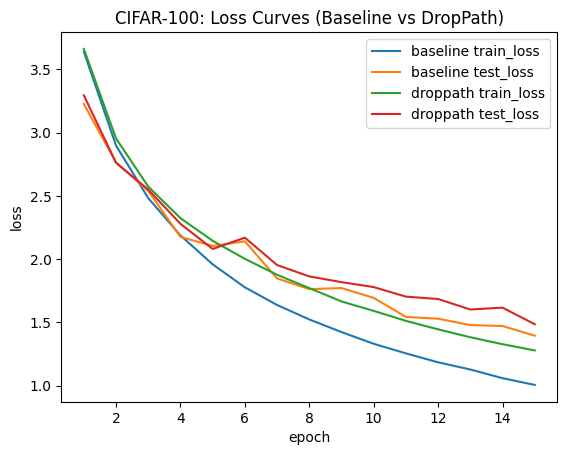

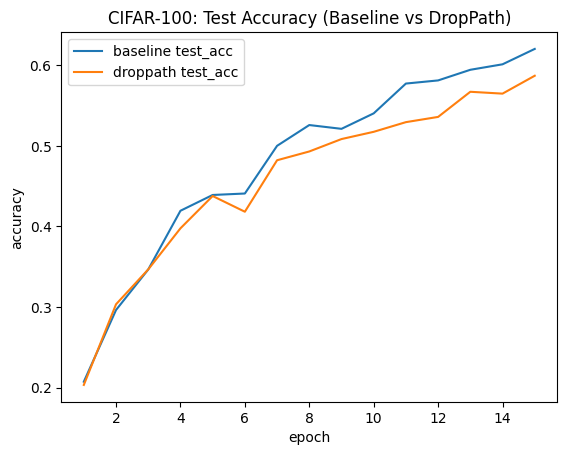

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, EPOCHS + 1))

plt.figure()
plt.plot(epochs, hist_base["train_loss"], label="baseline train_loss")
plt.plot(epochs, hist_base["test_loss"], label="baseline test_loss")
plt.plot(epochs, hist_dp["train_loss"], label="droppath train_loss")
plt.plot(epochs, hist_dp["test_loss"], label="droppath test_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CIFAR-100: Loss Curves (Baseline vs DropPath)")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, hist_base["test_acc"], label="baseline test_acc")
plt.plot(epochs, hist_dp["test_acc"], label="droppath test_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("CIFAR-100: Test Accuracy (Baseline vs DropPath)")
plt.legend()
plt.show()


## 7) Hızlı Check: Bir Batch Üzerinde Tahminler

- CIFAR-100 class isimleri ile birkaç örnek (gt vs pred) yazdırır.


In [11]:
classes = train_set.classes

@torch.no_grad()
def predict_batch(model: nn.Module, loader: DataLoader, device: str, k: int = 8):
    model.eval()
    x, y = next(iter(loader))
    x = x.to(device)
    y = y.to(device)
    logits = model(x)
    pred = logits.argmax(dim=1)
    return y[:k].cpu(), pred[:k].cpu()

yb, pb = predict_batch(baseline, test_loader, device, k=8)
yd, pd = predict_batch(droppath, test_loader, device, k=8)

print("Baseline preds:")
for i in range(len(yb)):
    print(f"  gt={classes[yb[i]]:>18s} | pred={classes[pb[i]]:>18s}")

print("\nDropPath preds:")
for i in range(len(yd)):
    print(f"  gt={classes[yd[i]]:>18s} | pred={classes[pd[i]]:>18s}")


Baseline preds:
  gt=          mountain | pred=            bridge
  gt=            forest | pred=         pine_tree
  gt=              seal | pred=         crocodile
  gt=          mushroom | pred=          mushroom
  gt=               sea | pred=               sea
  gt=             tulip | pred=            spider
  gt=             camel | pred=         crocodile
  gt=         butterfly | pred=            beetle

DropPath preds:
  gt=          mountain | pred=           dolphin
  gt=            forest | pred=            forest
  gt=              seal | pred=             otter
  gt=          mushroom | pred=               can
  gt=               sea | pred=               sea
  gt=             tulip | pred=               bee
  gt=             camel | pred=           tractor
  gt=         butterfly | pred=         butterfly


# Neden DropPath Daha Kötü Çıktı? (Bu Deney Özelinde)

Aşağıdaki sonuçlar:

- **Baseline**: `acc = 0.6203`
- **DropPath**: `acc = 0.5870`

Bu fark, “DropPath yanlış” demek değil. Bu deney koşullarında DropPath’in **fazla regularize** etmesi ve eğitimi “frenlemesi” demek.

---

## 1) Çıktıların Teşhisi (Kısa ve Net)

DropPath tarafında:

- `train_loss` daha yüksek (Baseline `1.0058` vs DropPath `1.2786`)
- `test_loss` daha yüksek (Baseline `1.3952` vs DropPath `1.4856`)
- `test_acc` daha düşük

Bu pattern genelde şunu gösterir:

> Model overfit olmadan önce bile “kısıtlandığı” için,
> hem öğrenmesi zorlaşıyor (train_loss ↑), hem de genelleme artmıyor (test_acc ↓).

Yani **underfitting** tarafına kaymışsın.

---

## 2) Bu Deneyde DropPath’in Kötüleşmesinin Ana Sebepleri

### (A) 15 epoch DropPath için kısa
DropPath, Stochastic Depth gibi yöntemler genelde:
- daha uzun eğitim (ör. 100–200 epoch),
- daha büyük modeller
için “kazanım” üretir.

15 epoch’ta baseline zaten “tam oturmadan” bitiyor.
DropPath ise daha baştan yolu kestiği için modelin öğrenmesi **yavaşlıyor**.

**Özet:** Kısa eğitimde regularizer, çoğu zaman “kazanım” değil “fren” olur.

---

### (B) Model küçük: 6 blok için `max_drop=0.1` agresif kalabilir
Senin backbone toplam **6 residual blok**.

DropPath schedule ile derinlere gittikçe oran büyüyor:
- en derin bloklarda oran `~0.1`’e yaklaşıyor.

Küçük modelde bu “fazla sert” olabilir.

**Sinyal:** train_loss baseline’den bariz yüksek → öğrenme kapasitesi kesiliyor.

---

### (C) Warmup (2000 step) kısa eğitimde “ayar kaçırabilir”
Warmup mantıklı olsa da, 15 epoch gibi kısa koşuda:
- DropPath’in ne zaman/kaç güçle devreye girdiği kritik hale gelir.
- 2000 step bazı koşullarda gereksiz/uygunsuz olabilir.

Warmup yanlış değil; ama bu deneye özel optimize edilmediği için performansı aşağı çekebilir.

---

### (D) Overfit yokken regularizer fayda vermez
Regularization (DropPath/DropBlock/Dropout) en çok şu durumda işe yarar:
- **train çok iyi**
- **test geride**
yani overfit varsa.

Bu deneyde baseline bile çok yüksek train performansına ulaşmış değil.
Dolayısıyla DropPath’in “düzeltmesi gereken” bir overfit yok.
